<a href="https://colab.research.google.com/github/esgryaznova/analyzing-hatespeech-SNA-2022/blob/main/SVD_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd

In [18]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
from collections import OrderedDict

In [20]:
import numpy as np

In [21]:
data = pd.read_csv("gpt_rubert_ruxl_gpt3_data.csv")

In [22]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

2022-06-22 09:25:01,635 : INFO : Инициализировали логгер


In [23]:
logger.info('num train samples %d', data.shape[0])
data.target_group.value_counts(normalize=True)
#сильный дисбаланс классов

2022-06-22 09:25:01,648 : INFO : num train samples 10382


man           0.236563
women         0.195049
other         0.184647
born_place    0.175978
lgbt          0.113658
migrants      0.051146
child         0.040551
migrant       0.002408
Name: target_group, dtype: float64

In [24]:
#data.info()

In [25]:
data.shape

(10382, 26)

In [26]:
# create a list of our conditions
conditions = [
    (data['Результат 1'] == False) & (data['Результат 2'] == False),
    (data['Результат 1'] == False) & (data['Результат 2'] == True),
    (data['Результат 1'] == True) & (data['Результат 2'] == False),
    (data['Результат 1'] == True) & (data['Результат 2'] == True),
    ]

# create a list of the values we want to assign for each condition
values = ['0', '1', '2', '3']

# create a new column and use np.select to assign values to it using our lists as arguments
data['respond'] = np.select(conditions, values)

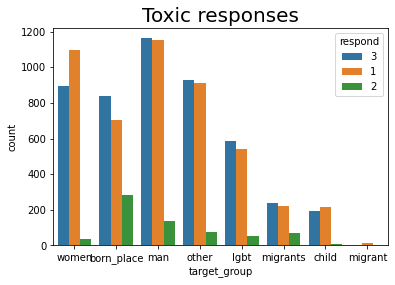

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title("Toxic responses", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "target_group", hue = 'respond', data = data)

In [28]:
data = data[["Реплика 2 toxicity", "target_group", "respond"]]

In [29]:
data = data.rename(columns={"Реплика 2 toxicity": "source", "target_group": "target"})

In [30]:
data['target'].value_counts()

man           2456
women         2025
other         1917
born_place    1827
lgbt          1180
migrants       531
child          421
migrant         25
Name: target, dtype: int64

In [31]:
import numpy as np

In [32]:
data.head()

,source,target,respond
0,слышишь блядь заткни свой ебальник сука,women,3
1,я высказал предположение что ... но естествен...,women,3
2,блядь сука пиздец вот повезло ебаный рот за чт...,women,1
3,в византии были государственные школы. до юсти...,women,1
4,лол мы чуть - не проебали сука я убил куры уби...,women,1


In [33]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)

In [34]:
train_data.head()

,source,target,respond
9962,"тебя ебет, чмоньдель? я таких как ты как семе...",women,3
1176,ты старый сын суки самый нищий кусок дерьма с ...,women,3
551,без американцев эти два клоуна недели не прож...,born_place,3
744,ну ты же пиздабол пруфы что я хохол не предост...,born_place,1
7012,демиург пидор потому что. да и по его воле же...,man,1


In [35]:
import networkx as nx

In [36]:
g = nx.from_pandas_edgelist(data, source='source', target='target')

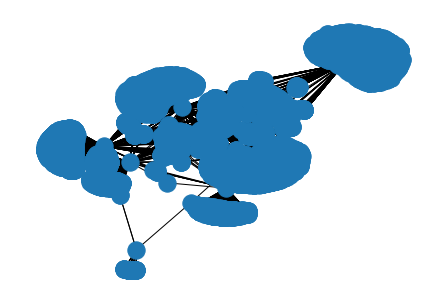

In [37]:
nx.draw(g)

In [38]:
edgelist=[]
ed_c=g.number_of_edges()
for e in g.edges():
    node1=e[0]
    node2=e[1]
    n_c=0
    n_c+=len([j for j in g.neighbors(node1)])
    n_c+=len([j for j in g.neighbors(node2)])
    normalized_count=n_c/ed_c
    g[e[0]][e[1]]['weight']=normalized_count

In [39]:
#nx.draw_networkx(g,pos=nx.spring_layout(g))

Дальше загружаем все для сети

In [40]:
import tensorflow as tf
from tensorflow.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.keras.layers import Dropout, Input, Layer, Embedding, Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import networkx as nx
import scipy
from sklearn.preprocessing import LabelEncoder

In [41]:
class GraphConvolution(tf.keras.layers.Layer):  # ReLU(AXW)

    def __init__(self, units,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0, 
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.seed = seed
       # self.graph=train
        
    def build(self, input_shapes):
        input_dim = int(input_shapes[0][-1])
        
        self.kernel = self.add_weight(shape=(input_dim,
                                             self.units),
                                      initializer=glorot_uniform(
                                          seed=self.seed),
                                      regularizer=l2(self.l2_reg),
                                      name='kernel' )
        
        self.bias = self.add_weight(shape=(self.units,),
                                        initializer=Zeros(),
                                        name='bias')

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True
        print('kernel shape',self.kernel.shape)
        print('input dimension',input_dim)
        
    def call(self, inputs, training=None, **kwargs):        
        features, A = inputs
        A=tf.sparse.to_dense(A)
        
        v1=tf.matmul(A,features)
        
        output = tf.matmul(A,self.kernel)
        output += self.bias
        act = self.activation(output)
        
        #act._uses_learning_phase = features._uses_learning_phase
        return act

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                 
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def GCN(adj_dim,feature_dim,n_hidden, num_class, num_layers=2,activation=tf.nn.relu,dropout_rate=0.5, l2_reg=0 ):
    Adj = Input(shape=(None,), sparse=True,name='first')
    
    X_in = Input(shape=(feature_dim,), sparse=False,name='second')
    emb = Embedding(adj_dim, feature_dim,
                        embeddings_initializer=Identity(1.0), trainable=False)
    X_emb = emb(X_in)
#     X_emb=LSTM(3235,return_sequences='True')(X_emb)
#     print('Xemb',X_emb)
#     H = Reshape([X_emb.shape[-1]])(X_emb)
    H=X_emb
    print('H shape',H)
        
#     print(type(Adj))
#     H=X_in
    for i in range(3):
        if i == num_layers - 1:
            activation = tf.nn.softmax
            n_hidden = num_class
        h = GraphConvolution(n_hidden, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([H,Adj])
    output = h
    model = Model(inputs=[X_in,Adj], outputs=output)
    print(model.summary())
    
    return model

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + scipy.sparse.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj


label_y= LabelEncoder()
labels=label_y.fit_transform(train_data['target'])

# y_train=list(set(list(labels)))

y_train=encode_onehot(labels)


In [42]:
g=nx.from_pandas_edgelist(train_data, source='source',target='target')
A=nx.adjacency_matrix(g) #,nodelist=range(g.number_of_nodes()))
A=preprocess_adj(A)
feature_dim = A.shape[-1]
X = np.arange(A.shape[-1])
X_n=[]
for i in range(feature_dim):
    X_n.append(X)
X=np.asarray(X_n)
# print('X',X)
model_input = [X, A]
# print('X',type(X))
# print('A',type(A))

# print('feature_dim',feature_dim)
model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
model.compile(optimizer='adam', loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

model.fit(model_input,y_train[:A.shape[-1]],epochs=20)

H shape KerasTensor(type_spec=TensorSpec(shape=(None, 5599, 5599), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")
kernel shape (5599, 32)
input dimension 5599
kernel shape (5599, 8)
input dimension 5599
kernel shape (5599, 8)
input dimension 5599
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 second (InputLayer)            [(None, 5599)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5599, 5599)   31348801    ['second[0][0]']                 
                                                                                                  
 first (InputLayer)             [(None, None)]       0           []  

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

Reading in Graph Data and training SVD

In [45]:
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_matrix(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print(edge)
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print('creating false train edges...')

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false


In [46]:
import scipy.sparse as sp

In [47]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape
    

In [48]:
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

Num. (test, val) edges requested: ( 1994 ,  664 )
Num. (test, val) edges returned: ( 1049 ,  0 )


In [49]:
# Inspect train/test split
print("Total nodes:", adj_sparse.shape[0])
print("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 5599
Total edges: 6647
Training edges (positive): 5598
Training edges (negative): 5598
Validation edges (positive): 0
Validation edges (negative): 664
Test edges (positive): 1049
Test edges (negative): 1994


In [50]:
def get_feature_matr(g):
    def f(pair):
      new_dict = pair[1]
      new_dict['ind'] = pair[0]
      return new_dict

    df = pd.DataFrame([f(x) for x in dict(g.nodes(data=True)).items()])
    
    needed_columns = list(df.columns)
    needed_columns.remove('dumb_id')
    needed_columns.remove('ind')

    feature_matr = df[needed_columns].to_numpy()
    print(f"Raw feature_matr. shape: {feature_matr.shape}\n{feature_matr}")
    

    feature_matr = feature_matr - feature_matr.mean(axis=0)
    feature_matr = feature_matr / feature_matr.std(axis=0)
    feature_matr = feature_matr[:, np.any(~np.isnan(feature_matr), axis=0)]

    assert feature_matr.shape[1] == int(feature_matr.std(axis=0).sum())

    print(f"Got {feature_matr.shape[1]} features after filtering\n{feature_matr}")
    return feature_matr

In [51]:
feature_matr = nx.adjacency_matrix(g_train)

In [52]:
def svd_embedding(m, emb_size):
    if sp.issparse(m):
        m = m.todense()
    U, S, VT = np.linalg.svd(m)
    mean_diff = (U[:, :emb_size] - VT[:emb_size, :].T).mean()
 #   assert mean_diff < 1e-7, f"Expected small difference in U and V. Got mean diff: {mean_diff}"
    return U[:, :emb_size]

svd_emb = svd_embedding(feature_matr, emb_size=200)

In [53]:
#create embeddings

In [54]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = np.squeeze(np.asarray(svd_emb[node_index]))
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [55]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
# Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [56]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
#val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_embs = neg_val_edge_embs
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [57]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=0)

In [58]:
# Predicted edge scores: probability of being of class "1" (real edge)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
#val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [59]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [60]:
#print('SVD Validation ROC score: ', str(val_roc))
print('SVD Validation AP score: ', str(val_ap))
print('SVD Test ROC score: ', str(test_roc))
print('SVD Test AP score: ', str(test_ap))

SVD Validation AP score:  nan
SVD Test ROC score:  0.32742555598157674
SVD Test AP score:  0.2869560446662278


In [61]:
import torch
from torch import nn
from torch.nn.functional import one_hot

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

class edge_classification(nn.Module):
  # pic -> embedding
    def __init__(self, ):
        super().__init__()
        
        self.prediction_stack = nn.Sequential(
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),
            
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        predictions = self.prediction_stack(x)
        return predictions

Using cuda


In [62]:
len(train_edge_embs[0])

200

In [63]:
from torch.utils.data import DataLoader

def make_np_dataloader(edge_embs, labels, batch_size=100):
    assert len(labels) == len(edge_embs)

    data = np.hstack((edge_embs, labels[np.newaxis].T))

    t = torch.tensor(data, dtype=torch.float32).to(device)
    return DataLoader(t, batch_size=batch_size)

train_dl = make_np_dataloader(train_edge_embs, train_edge_labels, batch_size=1000)
test_dl = make_np_dataloader(test_edge_embs, test_edge_labels, batch_size=100_000)

In [64]:
def train_loop(config):
    config['model'].train()

    for epoch in range(config['epochs']):
        losses = []
        for batch, data in enumerate(train_dl):
            X = data[:, :-1].to(device)
            y = data[:, -1].to(torch.float32).to(device)

            # Compute prediction and loss
            pred = config['model'](X)
            
            pred_for_loss = pred.T[0]
            gt_for_loss = y.to(torch.float32)

            loss = config['loss_fn'](pred_for_loss, gt_for_loss)

            # Backpropagation
            
            config['optimizer'].zero_grad()
            loss.backward()
            config['optimizer'].step()

            loss = loss.item()
            losses.append(loss)
        print(f"Epoch {epoch} avg loss: {np.mean(losses)}")

def test_loop(config):
    config['model'].eval()
    predictions = []
    labels = []
    losses = []
    for data in test_dl:
        X = data[:, :-1].to(device)
        y = data[:, -1].to(torch.float32).to(device)

        # Compute prediction and loss
        pred = config['model'](X)
        
        pred_for_loss = pred.T[0]
        gt_for_loss = y.to(torch.float32)

        labels.append(gt_for_loss.cpu())
        predictions.append(pred_for_loss.cpu())

        loss = config['loss_fn'](pred_for_loss, gt_for_loss)

        loss = loss.item()
        losses.append(loss)
    
    all_labels = torch.cat(labels).detach().numpy()
    all_predictions = torch.cat(predictions).detach().numpy()

    eval_model(all_labels, all_predictions, test_edge_embs)
    print(f"    Avg loss: {np.mean(losses)}")

def eval_model(labels, predictions, edges):
    val_roc = roc_auc_score(labels, predictions)
    val_ap = average_precision_score(labels, predictions)

    roc_score = roc_auc_score(labels, predictions)
    ap_score = average_precision_score(labels, predictions)

    print(f"""Test:
    AP: {(ap_score):>0.3f} 
    ROC: {(roc_score):>0.3f}""")

In [65]:
config = {
    'learning_rate': 5e-1,
    'epochs': 50,
    'big_epochs': 50,
    'model': edge_classification().to(device),
    'loss_fn': torch.nn.BCELoss(),
}

config['optimizer'] = torch.optim.SGD(config['model'].parameters(), lr=config['learning_rate'])

In [66]:
for i in range(config['big_epochs']):
    print(f"--------------BIG EPOCH {i}--------------")
    train_loop(config)
    test_loop(config)

--------------BIG EPOCH 0--------------
Epoch 0 avg loss: 0.6459476252396902
Epoch 1 avg loss: 0.7212445785601934
Epoch 2 avg loss: 0.7279457971453667
Epoch 3 avg loss: 0.7284804607431093
Epoch 4 avg loss: 0.7285203362504641
Epoch 5 avg loss: 0.7285356024901072
Epoch 6 avg loss: 0.7285363624493281
Epoch 7 avg loss: 0.728527195751667
Epoch 8 avg loss: 0.7285268778602282
Epoch 9 avg loss: 0.7285234158237776
Epoch 10 avg loss: 0.7285192956527075
Epoch 11 avg loss: 0.7285138616959254
Epoch 12 avg loss: 0.7285112366080284
Epoch 13 avg loss: 0.7285130694508553
Epoch 14 avg loss: 0.7285183916489283
Epoch 15 avg loss: 0.7285101885596911
Epoch 16 avg loss: 0.7285082414746284
Epoch 17 avg loss: 0.7285138343771299
Epoch 18 avg loss: 0.7285011013348898
Epoch 19 avg loss: 0.7285107995073
Epoch 20 avg loss: 0.7285046055912971
Epoch 21 avg loss: 0.7285135264197985
Epoch 22 avg loss: 0.7285129154721895
Epoch 23 avg loss: 0.7285000731547674
Epoch 24 avg loss: 0.728501483798027
Epoch 25 avg loss: 0.7285